In [1]:
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glacierml as gl
from tqdm import tqdm
from scipy import stats
from scipy.stats import gaussian_kde

pd.set_option('display.max_column',None)

2024-04-26 10:07:59.753639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 10:07:59.797269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 10:07:59.797956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 10:08:00.491579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
home_path = '/home/simonhans/glacierml'
[
        data_path, RGI_path, glathida_path, ref_path,
        coregistration_testing_path, 
        arch_test_path, LOO_path
] = gl.set_paths(home_path)

In [3]:
print(np.__version__)

1.23.5


#### Let's do a calculation.
#### ${S} \approx \sum_{k=1}^{N_k} \hat{V}_  k \pm Z^*_{\alpha / 2} \sqrt{\sum_k^{N_k} \sigma^2_k}$

First, let's load data

In [4]:
cols, df = gl.load_LOO_data(home_path, include_train = False, include_refs = False)
cols, train = gl.load_LOO_data(home_path, include_train = True, include_refs = False)

# E_delta_a, areas, cols, train = gl.load_LOO_data(include_train = True)
# E_delta_a, areas, cols, df = gl.load_LOO_data(include_train = False)
g = (
    pd.read_csv(glathida_path + '/T.csv')[
        ['AREA','MEAN_THICKNESS_UNCERTAINTY','MEAN_THICKNESS']
    ]
)
g = g.rename(columns = {
    'MEAN_THICKNESS_UNCERTAINTY':'u',
    'AREA':'a',
    'MEAN_THICKNESS':'t'
})
g.u = g.u/1e3
g.t = g.t/1e3
g = g.dropna(subset = ['u'])
df[cols] = df[cols]/1e3
train[cols] = train[cols]/1e3
train['Thickness'] = train['Thickness'] / 1e3

In [5]:
ref = pd.read_pickle(os.path.join(home_path,'data/reference_thicknesses/refs.pkl'))

#### For the case of independent variables, $\sigma^2_k =  \left(\sigma^H_k\right)^2 \left(\sigma^A_k\right)^2 + {A}_k^2 \left(\sigma^H_k\right)^2 
     +  H_k^2 \left(\sigma^A_k\right)^2$

#### Let $\left(\sigma^H_k\right)^2 = \text{Var}\left(\epsilon^{\mathcal{H}}_k\right) + \text{Var}\left(\epsilon^{\mathcal{R}}_k\right) +\text{Var}\left(\epsilon^{\mathcal{M}}_k\right)$,

<!-- % #### and $\text{Var}\left(\epsilon^{\mathcal{H}}_k\right) \approx \text{Var}_j\left(\mathcal{H}_{kj}\right)$, -->

#### and $\text{Var}\left(\epsilon^{\mathcal{H}}_k\right) \approx \text{Var}_j\left(\mathcal{H}_{kj}\right)$,

<!-- #### and $\text{Var}\left(\epsilon^{\mathcal{R}}_B\right) \approx \frac{1}{n_B n_j}\sum_B^{n_B}\sum_{j}^{n_j} \left(r_{jB} - \mu_{r_B}\right)^2$, -->

#### and $\text{Var}\left(\epsilon^{\mathcal{R}}_B\right) \approx \text{Var}_j \left(\mathcal{R}_{jB}\right)$,

#### and $\text{Var}\left(\epsilon^{\mathcal{M}}_i\right) \approx \text{Var} \left(\mathcal{M}_{i}\right)$

#### Start with $\text{Var}\left(\epsilon^{\mathcal{H}}_k\right)\approx \text{Var}_j\left(\mathcal{H}_{kj}\right)$

In [6]:
### epsilonH is the uncertainty due to limited training data ###
### var(epsilonH) represents variance of  ###
# var_eps_H = (1/(len(cols) - 1)*np.sum(
#     df[cols].sub(np.mean(df[cols],axis = 1),axis = 0)**2,axis = 1
# )
var_eps_H = np.var(df[cols],axis = 1)
df = pd.concat([df,pd.Series(var_eps_H,name = 'var_eps_H')],axis = 1)

#### That was easy. Now for  $\text{Var}\left(\epsilon^{\mathcal{R}}_B\right) \approx \text{Var}_j \left(\mathcal{R}_{jB}\right)$

In [7]:
### Calculate Var(epsR_B) ###
### First bin residuals ###
bins = []
[bins.append(x/1e3) for x in range(1, 300, 1)]
bins.append(0)
bins = np.sort(bins).tolist()
names = [str(x) for x in bins]
bins.append(np.inf)
train = pd.concat(
    [
        train,
         pd.cut(train['Thickness'], bins, labels=names).rename('bin')
    ],axis = 1
)
train['bin'] = train['bin'].astype(float)
bins = train['bin'].sort_values().unique().tolist()

In [8]:
### Iterate through residuals and calculate a standard deviation ###
c = dict.fromkeys(bins)
re = dict.fromkeys(bins)

for n,i in tqdm(enumerate(c.keys())):    
    if i <= 170/1e3:
        j = i + 1/1e3
    if i > 170/1e3:
        j = i - 10/1e3
    dft = train[
        (train['bin'] == i)       
               ]
    while len(dft) < 2:
        if i <= 95/1e3:
            j +=1/1e3
            dft = train[
            (train['bin'] >= i)&
            (train['bin'] <= j)       
                   ]
        if i >= 95/1e3 and i < 170/1e3:
            j +=10/1e3
            dft = train[
            (train['bin'] >= i)&
            (train['bin'] <= j)       
                   ]
        if i > 170/1e3:
            j -=10/1e3
            dft = train[
            (train['bin'] <= i)&
            (train['bin'] >= j)       
                   ]
        
    h = dft[cols]
    r = h.subtract(dft['Thickness'], axis=0)
    c[i] = np.std(r.to_numpy().flatten())
    re[i] = np.mean(r.to_numpy(), axis=0) 
stds = np.fromiter(c.values(), dtype=float)


99it [00:02, 40.40it/s]


#### Now we can fit $\sqrt{\text{Var}_j \left(\mathcal{R}_{jB}\right)}$ to $h_B$.

0.04
0.6


Text(0, 0.5, '$\\sigma^{\\mathcal{R}}_B$ (km)')

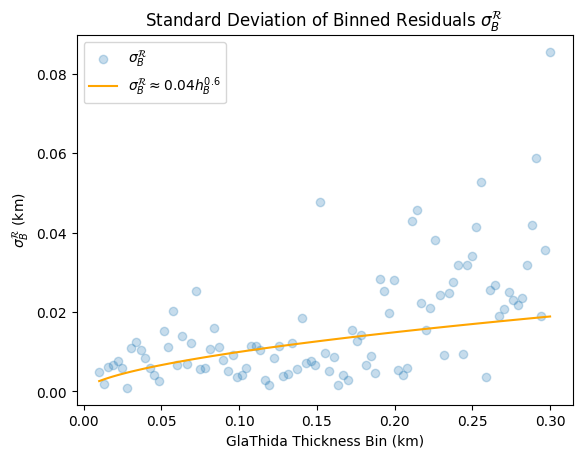

In [9]:
### Fit a statistical model to the range 
z = np.linspace(0.01,0.3,99) 
# z = train['Thickness']
model = np.poly1d(np.polyfit(np.log(z),np.log(stds), 1))

c1 = np.round(np.exp(model[0]),2)
c2 = np.round((model[1]),1)
print(c1)
print(c2)


plt.scatter((z),(stds),alpha = 0.25,label = r'$\sigma^{\mathcal{R}}_B$')
plt.plot((z),np.exp(model(np.log(z))),
                    label = rf'$\sigma^{{\mathcal{{R}}}}_B \approx {c1} h_B^{{{c2}}} $',
        c = 'orange'
        )
plt.legend()
plt.title(r'Standard Deviation of Binned Residuals $\sigma^{\mathcal{R}}_B$')
plt.xlabel('GlaThida Thickness Bin (km)')
plt.ylabel(r'$\sigma^{\mathcal{R}}_B$ (km)')

#### Apply to $H_k$ and we're done

In [10]:
### Apply statistical model of residuals to mean estimated thickness ###
var_eps_R = (np.mean((c1*df[cols]**c2),axis = 1))**2
df = pd.concat([df,pd.Series(var_eps_R,name = 'var_eps_R')],axis = 1)

#### now for $\text{Var}\left(\epsilon^{\mathcal{M}}_m\right) \approx \text{Var}\left(\mathcal{M}_{m}\right)$. 

#### GlaThiDa reports a thickness uncertainty. Consider this a std dev $\sigma^{\mathcal{M}}_m$ where $n_m < n_i$. We can do as we did with variance of residuals and fit another statistical model.

#### Fit a a statistical model with $\sqrt{\text{Var}\left(\mathcal{M}_{m}\right)}$ as the dependent variable to corresponding measured thickness $h_m$.

0.07
0.8


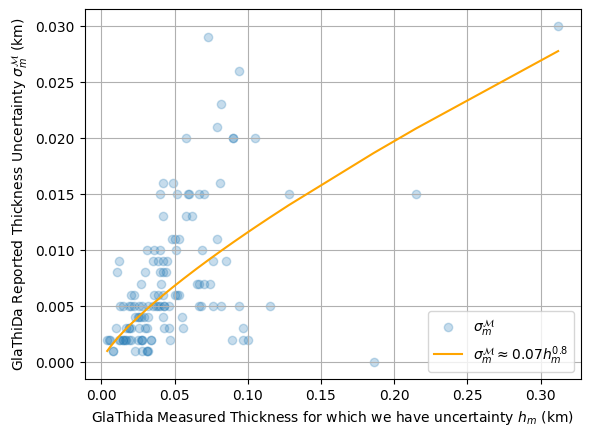

In [11]:
u = []
for i in g.u:
    g_u = gl.findlog(i)
    u.append(g_u)
u = np.array(u)
### Fit a statistical model to the range 
# z = np.linspace(g.a.min(),g.a.max(),len(g)) 
# z = train['Thickness']
model = np.poly1d(np.polyfit(np.log(g.t),(u), 1))

c3 = np.round(np.exp(model[0]),2)
c4 = np.round((model[1]),1)
print(c3)
print(c4)


plt.scatter((g.t),(g.u),alpha = 0.25,label = r'$\sigma^{\mathcal{M}}_m$')
plt.plot(np.sort(g.t),np.exp(model(np.log(np.sort(g.t)))),
                    label = rf'$\sigma^{{\mathcal{{M}}}}_m \approx {c3} h_m^{{{c4}}} $',
         c = 'orange'
        )
plt.legend()
# plt.title(r'Standard Deviation of Binned Residuals $\sigma^{\mathcal{R}}_B$')
plt.xlabel('GlaThida Measured Thickness for which we have uncertainty $h_m$ (km)')
plt.ylabel(r'GlaThiDa Reported Thickness Uncertainty $\sigma^{\mathcal{M}}_m$ (km)')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(which = 'both')

#### Apply to $H_k$ and we're done

In [12]:
var_eps_M = (np.mean((c3*df[cols]**c4),axis = 1))**2
df = pd.concat([df,pd.Series(var_eps_M,name = 'var_eps_M')],axis = 1)

#### Okay, thinking about residuals. We have captured the variance of residuals, but we haven't really considered the accuracy of our residuals Var($\epsilon^{\mathcal{RA}}$)

In [13]:
### Put them together ###
var_H = var_eps_H + var_eps_R + var_eps_M
df = pd.concat([df,pd.Series(var_H,name = 'var_H')],axis = 1)

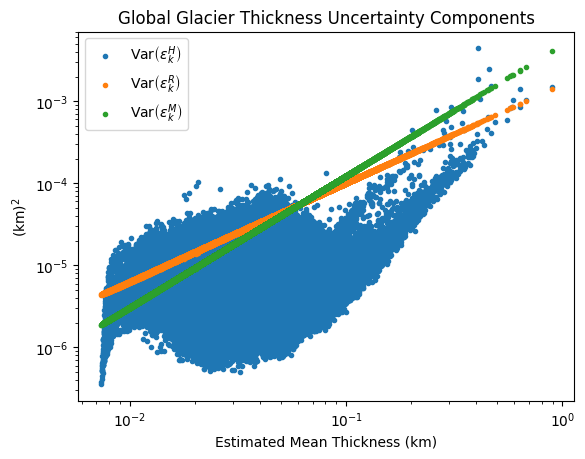

In [14]:
h = np.mean(df[cols],axis = 1)
# xy = np.vstack([np.log10(h),np.log10(var_eps_H)])
# print('calculating density')
# z = gaussian_kde(xy)(xy)
# np.save('epsh_z.npy',z)
# z = np.load('epsh_z.npy')
# plt.scatter(h,var_eps_H,label = 'h')
plt.scatter(h,(var_eps_H),label = r'Var$\left(\epsilon^H_k\right)$',marker = '.')

plt.scatter(h,(var_eps_R),label = r'Var$\left(\epsilon^R_k\right)$',marker = '.')
plt.scatter(h,var_eps_M,label = r'Var$\left(\epsilon^M_k\right)$',marker = '.')
plt.xlabel('Estimated Mean Thickness (km)')
plt.ylabel('(km)$^2$')
plt.title('Global Glacier Thickness Uncertainty Components')
plt.legend()
# plt.scatter(np.mean(df[cols],axis = 1),var_eps_H)
# plt.scatter(np.mean(df[cols],axis = 1),var_eps_H + var_eps_R + var_eps_M)
# plt.scatter(np.mean(df[cols],axis = 1),np.mean(df[cols],axis = 1))
plt.yscale('log')
plt.xscale('log')

#### Okay, we have $(\sigma^H_k)^2$ calculated and appended.
#### Let's calculate $(\sigma^A_k)^2$. We follow the procedure set out by Pfeffer et al. 2019.

In [15]:
k = 3
p = 0.7
e1 = 0.039
var_A = (k*e1*(df['Area']**p))**2
df = pd.concat([df,pd.Series(var_A,name = 'var_A')],axis = 1)

#### That was easy. Now what is left?
#### Let $H_k = \frac{1}{N_j}\sum_{j=1}^{N_j} \mathcal{H}_{kj}$, and $A_k$ be the reported RGI Area

In [16]:
### Calculation for variance of independent variables. ###
E_A = df['Area']
E_H = np.mean(df[cols],axis = 1)

v1 = (var_H * var_A)
v2 = (var_H * E_A**2) 
v3 = (E_H**2 * var_A)
sigma_k_ind = v1 + v2 + v3 
df = pd.concat([df,pd.Series(sigma_k_ind,name = 'sig_k_ind')],axis = 1)

#### ${S} \approx \sum_{k=1}^{N_k} \hat{V}_k \pm Z^*_{\alpha / 2} \sqrt{\sum_k^{N_k} \sigma^2_k}$

In [17]:
si = df['sig_k_ind'] # = (Var(H)*Var(A) + A^2Var(H) + H^2Var(A))

sp = np.sum(si)

se = np.sqrt(sp)

Z = (1.96)
Vlb = ( (np.sum(E_H * E_A) - (Z*se)) ) / 1e3
Vub = ( (np.sum(E_H * E_A) + (Z*se)) ) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {((Vub + Vlb) / 2)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[133.16981703759924,138.05966904507218]  * 10^3 km^3
Mid CI: 135.61474304133571 * 10^3 km^3
CI Half Width: 2.445 * 10^3 km^3


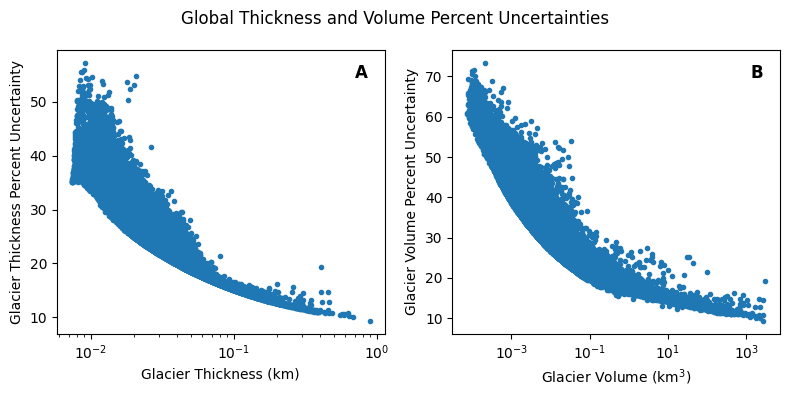

In [21]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
x = E_H
y = (np.sqrt(var_H) / (E_H)) * 100
# if not os.path.exists('thickness_z.npy'):
#     print('poop')
#     xy = np.vstack([np.log10(x),np.log10(y)])
#     print('calculating density')
#     z = gaussian_kde(xy)(xy)
#     np.save(z,'thickness_z.npy')
# else:
#     z = np.load('thickness_z.npy')
ax[0].scatter(E_H, (np.sqrt(var_H) / (E_H)) * 100, marker='.',
              label=r'$\sigma_k / H_k \times 100$')
ax[0].set_xscale('log')
ax[0].set_ylabel('Glacier Thickness Percent Uncertainty')
ax[0].set_xlabel('Glacier Thickness (km)')

x = E_H * E_A
y = (np.sqrt(df['sig_k_ind']) / (E_H * E_A)) * 100
# if not os.path.exists('thickness_z.npy'):
#     xy = np.vstack([np.log10(x),np.log10(y)])
#     print('calculating density')
#     z = gaussian_kde(xy)(xy)
#     np.save(z,'vol_z.npy')
# else:
#     z = np.load('vol_z.npy')
ax[1].scatter(x, y, marker='.')

ax[1].set_xscale('log')
ax[1].set_ylabel('Glacier Volume Percent Uncertainty')
ax[1].set_xlabel('Glacier Volume (km$^3$)')

fig.suptitle('Global Thickness and Volume Percent Uncertainties')

# Add labels 'A' and 'B' to upper-right corners of the axes
ax[0].text(0.95, 0.95, 'A', transform=ax[0].transAxes, fontsize=12, ha='right', va='top', fontweight='bold')
ax[1].text(0.95, 0.95, 'B', transform=ax[1].transAxes, fontsize=12, ha='right', va='top', fontweight='bold')

plt.tight_layout()
plt.show()

Text(0.5, 1.05, 'Global Glacier Thickness Uncertainty')

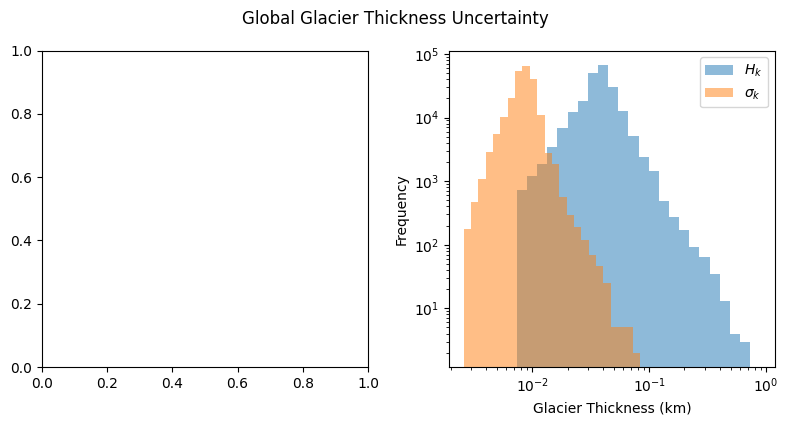

In [22]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

# ax[0].legend()

# ax[0].set_yscale('log')
# ax[0].set_title('Global Glacier Volume Percent Uncertainty')

X = E_H
Y = np.sqrt(var_H)

bins_X = np.logspace(np.log10(np.min(X)), np.log10(np.max(X)), 25)
bins_Y = np.logspace(np.log10(np.min(Y)), np.log10(np.max(Y)), 25)

# fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[1].hist(X,bins = bins_X,alpha = 0.5,log = True,label = r'${H}_k$')
ax[1].hist(Y,bins = bins_Y,alpha = 0.5,log = True,label = r'${\sigma_k}$')
ax[1].set_xscale('log')
ax[1].set_xlabel('Glacier Thickness (km)')
ax[1].set_ylabel('Frequency')
ax[1].legend()
plt.tight_layout()
fig.suptitle('Global Glacier Thickness Uncertainty',y = 1.05)

Text(0.5, 1.05, 'Global Glacier Thickness Uncertainty')

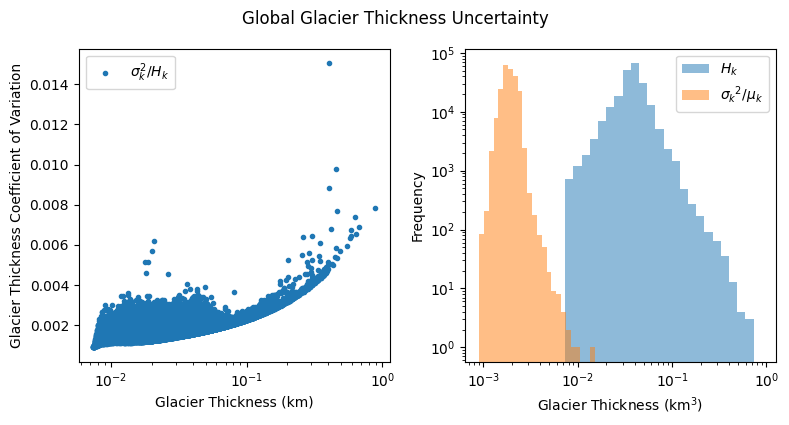

In [23]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

ax[0].scatter(E_H,((var_H)/(E_H)),marker = '.',
              label = r'$\sigma_k^2 / H_k $')
ax[0].set_xscale('log')
# plt.yscale('log')
ax[0].set_ylabel('Glacier Thickness Coefficient of Variation')
ax[0].set_xlabel('Glacier Thickness (km)')
ax[0].legend()
              
# ax[0].set_yscale('log')
# ax[0].set_title('Global Glacier Volume Percent Uncertainty')

X = E_H
Y = (var_H) / E_H

bins_X = np.logspace(np.log10(np.min(X)), np.log10(np.max(X)), 25)
bins_Y = np.logspace(np.log10(np.min(Y)), np.log10(np.max(Y)), 25)

# fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[1].hist(X,bins = bins_X,alpha = 0.5,log = True,label = r'${H}_k$')
ax[1].hist(Y,bins = bins_Y,alpha = 0.5,log = True,label = r'${{\sigma_k}^2}/{\mu_k}$')
ax[1].set_xscale('log')
ax[1].set_xlabel('Glacier Thickness (km$^3$)')
ax[1].set_ylabel('Frequency')
ax[1].legend()
plt.tight_layout()
fig.suptitle('Global Glacier Thickness Uncertainty',y = 1.05)

Text(0.5, 1.05, 'Global Glacier Thickness Uncertainty')

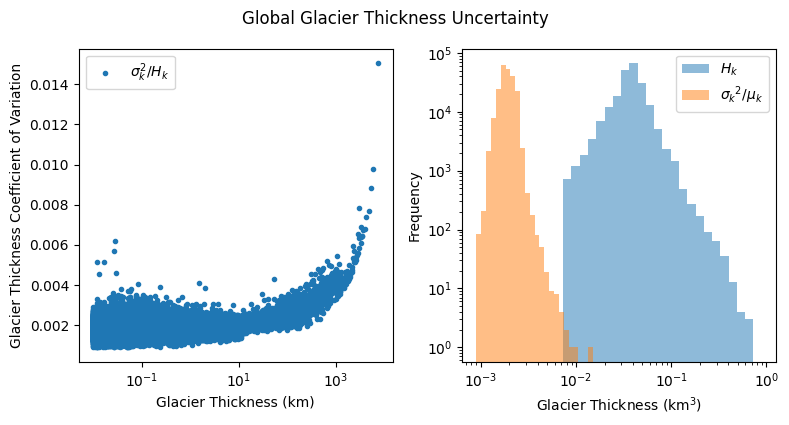

In [24]:
fig, ax = plt.subplots(1,2,figsize = (8,4))

ax[0].scatter(E_A,((var_H)/(E_H)),marker = '.',
              label = r'$\sigma_k^2 / H_k $')
ax[0].set_xscale('log')
# plt.yscale('log')
ax[0].set_ylabel('Glacier Thickness Coefficient of Variation')
ax[0].set_xlabel('Glacier Thickness (km)')
ax[0].legend()
              
# ax[0].set_yscale('log')
# ax[0].set_title('Global Glacier Volume Percent Uncertainty')

X = E_H
Y = (var_H) / E_H

bins_X = np.logspace(np.log10(np.min(X)), np.log10(np.max(X)), 25)
bins_Y = np.logspace(np.log10(np.min(Y)), np.log10(np.max(Y)), 25)

# fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[1].hist(X,bins = bins_X,alpha = 0.5,log = True,label = r'${H}_k$')
ax[1].hist(Y,bins = bins_Y,alpha = 0.5,log = True,label = r'${{\sigma_k}^2}/{\mu_k}$')
ax[1].set_xscale('log')
ax[1].set_xlabel('Glacier Thickness (km$^3$)')
ax[1].set_ylabel('Frequency')
ax[1].legend()
plt.tight_layout()
fig.suptitle('Global Glacier Thickness Uncertainty',y = 1.05)

0.30136581355282427


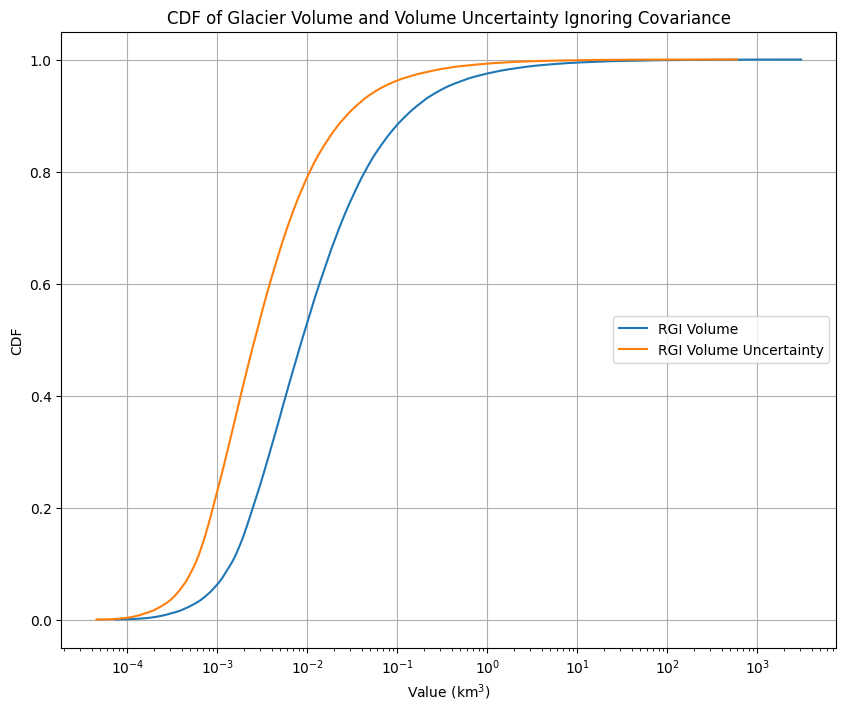

In [25]:
data_1 = np.mean(df[cols],axis = 1) * df['Area']
data_2 = np.sqrt(df['sig_k_ind'])

ks_stat, p_value = stats.ks_2samp(data_1, data_2)
print(ks_stat)
# data_2 = data['FMT'] * data['Area']
#sort data

fig = plt.subplots(1,1,figsize = (10,8))
cdf_data_1 = np.sort(data_1)
cdf_data_2 = np.sort(data_2)


cdf1 = np.arange(len(data_1)) / float(len(data_1))
cdf2 = np.arange(len(data_2)) / float(len(data_2))


plt.plot(cdf_data_1, cdf1, label='RGI Volume')
plt.plot(cdf_data_2, cdf2, label='RGI Volume Uncertainty')

plt.title('CDF of Glacier Volume and Volume Uncertainty Ignoring Covariance')
plt.xlabel('Value (km$^3$)')
plt.ylabel('CDF')
plt.legend(loc = 'center right')
plt.xscale('log')
plt.grid()
plt.show()

In [30]:
df.to_pickle('final.pkl')
# df.to_pickle('/data/fast1/glacierml/data/final_df.pkl')

#### And that's it for this notebook. For a further breakdown of variance components see variance_analysis.ipynb